In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.discrete.discrete_model import NegativeBinomial
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pickle import dump

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_2016_f = '2016_grazing_time_gridded_all_extracted.csv'
griddata_2017_f = '2017_grazing_time_gridded_all_extracted.csv'
griddata_2018_f = '2018_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))
    
if not os.path.exists(os.path.join(outDIR, 'results_tables/')):
    os.mkdir(os.path.join(outDIR, 'results_tables/'))

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_2016 = pd.read_csv(os.path.join(inDIR, griddata_2016_f))
df_wkly_grid_2017 = pd.read_csv(os.path.join(inDIR, griddata_2017_f))
df_wkly_grid_2018 = pd.read_csv(os.path.join(inDIR, griddata_2018_f))

df_wkly_grid_full = df_wkly_grid_2016.append(df_wkly_grid_2017.append(df_wkly_grid_2018))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
dCorner         float64
TPC_c            object
dtype: object

In [4]:
"""
Add season to dataset based on week and year based on Steer_ID
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])
df_wkly_grid_full['Year'] = df_wkly_grid_full['Steer_ID'].apply(lambda x: int(x.split('_')[-1]))

In [5]:
"""
Calculate all pasture combos where at least n-1 pasture are available 4 weeks per season
"""
df_seas_unique = df_wkly_grid_full.groupby(['Year', 'week']).agg({'Pasture': lambda x: x.unique(),
                                                                  'Steer_ID': lambda x: x.unique()}).reset_index()
df_seas = df_seas_unique.groupby(['Year', 'week']).agg(
    {'Pasture': lambda x: [i for i in list(df_wkly_grid_full['Pasture'].unique()) if all(i in y for y in x)],
     'Steer_ID': lambda x: [i for i in list(df_wkly_grid_full['Steer_ID'].unique()) if all(i in y for y in x)]}).reset_index()
df_seas['season'] = df_seas['week'].apply(lambda x: season_func(x))
df_combo_results = pd.DataFrame(columns=['n_pasture', 'past_list', 'Year', 'season', 'n_weeks', 'week_list'])
for r in tqdm(range(5, 10)):
    past_combos = list(itertools.combinations(df_wkly_grid_full['Pasture'].unique(), r))
    for combo in past_combos:
        #print(list(combo))
        # create mask of final weeks based on pastures
        wk_mask = [sum(j in i for j in list(combo)) > (r-2) for i in df_seas['Pasture']]
        df_tmp = df_seas[wk_mask].groupby(['Year', 'season'])['week'].count().reset_index()
        df_tmp['n_pasture'] = r
        df_tmp['past_list'] = pd.Series(list(np.tile(list(combo), (len(df_tmp), 1)).astype('object')))
        df_tmp['week_list'] = pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (len(df_tmp), 1)).astype('object')))
        df_tmp = df_tmp.rename(columns={'week': 'n_weeks'})
        for (yr, seas), grp_data in df_seas.groupby(['Year', 'season']):
            if len(df_tmp[(df_tmp['Year'] == yr) & (df_tmp['season'] == seas)]) == 0:
                #print(yr, seas)
                df_tmp = df_tmp.append(pd.DataFrame({'Year': yr,
                                                     'season': seas,
                                                     'n_weeks': 0,
                                                     'n_pasture': r,
                                                     'past_list': pd.Series(list(np.tile(list(combo), (1, 1)).astype('object'))),
                                                     'week_list': pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (1, 1)).astype('object')))}))
        df_combo_results = df_combo_results.append(df_tmp)
    df_combo_results['past_list_str'] = df_combo_results['past_list'].apply(lambda x: '_'.join(x))

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
min_weeks = 4
past_combos_gt_n = df_combo_results.groupby(
    'past_list_str')['n_weeks'].min()[df_combo_results.groupby(
    'past_list_str')['n_weeks'].min() >= min_weeks].index.values
max_pasts = df_combo_results[df_combo_results['past_list_str'].isin(past_combos_gt_n)]['n_pasture'].max()
display(df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                         (df_combo_results['n_pasture'] == max_pasts)])

,n_pasture,past_list,Year,season,n_weeks,week_list,past_list_str
0,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
1,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,late,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
2,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,mid,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
3,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,early,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
4,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,late,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
5,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,mid,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
6,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
7,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,late,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
8,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,mid,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE


In [7]:
train_pasts = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['past_list_str'].str.split('_')[0]
train_weeks = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['week_list'][0]
df_wkly_grid_full['mod_data'] = 'test'
df_wkly_grid_full.loc[(df_wkly_grid_full['Pasture'].isin(train_pasts)) &
                      (df_wkly_grid_full['week'].isin(train_weeks)), 'mod_data'] = 'train'

In [8]:
df_wkly_grid_full.groupby(['Year', 'mod_data'])['Pasture'].unique()

Year  mod_data
2016  test                                       [24W, 5E, 19N]
      train               [7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]
2017  test                       [24W, 15E, 26E, 25SE, 5E, 19N]
      train               [17N, 20SE, 15E, 25SE, 31E, 7NW, 26E]
2018  test        [24W, 26E, 25SE, 5E, 15E, 19N, 7NW, 17N, 31E]
      train               [7NW, 17N, 15E, 26E, 25SE, 31E, 20SE]
Name: Pasture, dtype: object

In [9]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dFence'] > 0]

'Number of grazing values > 10,000 = 1'

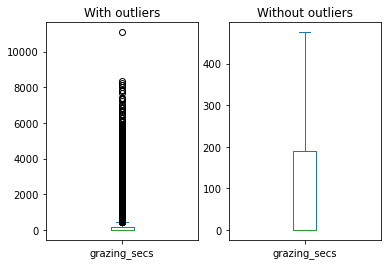

In [10]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > max_graze_secs])))

In [11]:
# drop grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] < max_graze_secs].copy(deep=True)

# convert grazing secs to integer
df_wkly_grid_full['grazing_secs'] = df_wkly_grid_full['grazing_secs'].astype('int')

In [12]:
"""
Flag and remove any outliers beyond last bin with only one pixel
"""

secs_bin_size = 60 * 5

def flag_graze_outliers(x, bins=np.arange(-5, max_graze_secs, secs_bin_size)):
    try:
        groups = x.groupby(pd.cut(x, bins, include_lowest=False))
        one_bins = bins[:-1][(groups.count() == 1).values] 
        gt_one_bins = bins[:-1][(groups.count() > 1).values] 
        last_one_bin = np.min([np.max(gt_one_bins) + secs_bin_size, np.max([np.min(one_bins), np.max(gt_one_bins)])])
        return (x >= last_one_bin).astype('int')
    except ValueError:
        return 0

df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    90.000000
mean      2.133333
std       1.697321
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       8.000000
Name: grazing_secs_outlier, dtype: float64

In [13]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [15]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scale_vars = True
scaler = StandardScaler()
if scale_vars:
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        for seas in ['early', 'mid', 'late']:
            for yr in df_wkly_grid_full['Year'].unique():
                scaler.fit(df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) & 
                                                 (df_wkly_grid_full['mod_data'] == 'train') &
                                                 (df_wkly_grid_full['Year'] == yr), c].values.reshape(-1, 1))
                with open(os.path.join(outDIR, 'scaler_' + str(yr) + '_' + seas + '_' + c + '.pkl'), 'wb') as f:
                    dump(scaler, f)
                vals_scaled_tmp = scaler.transform(
                    df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                          (df_wkly_grid_full['Year'] == yr), c].values.reshape(-1, 1)).flatten()
                df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                      (df_wkly_grid_full['Year'] == yr), c + '_orig'] = df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                                                       (df_wkly_grid_full['Year'] == yr), c].values
                df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                      (df_wkly_grid_full['Year'] == yr), c] = vals_scaled_tmp
#for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
#    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [24]:
df_wkly_grid_full['season_str'] = df_wkly_grid_full['season'].astype(str)#.value_counts()

In [25]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'test'].groupby(['Pasture',
                                                                                        'season_str',
                                                                                        'Year',
                                                                                        'UTM_X',
                                                                                        'UTM_Y']).agg(func={
    'Biomass': np.mean,
    'CP': np.mean,
    'DOM': np.mean,
    'dFence': np.mean,
    'dTank': np.mean,
    'dCorner': np.mean,
    'PC_div': np.mean,
    'TPC_c': lambda x: x.iloc[0],
    'PC_dmt': lambda x: x.iloc[0],
    'grazing_secs': np.sum,
    'mod_data': lambda x: x.iloc[0]
}).reset_index()

df_wkly_grid = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train'].groupby(['Pasture',
                                                                                        'season_str',
                                                                                        'Year',
                                                                                        'UTM_X',
                                                                                        'UTM_Y']).agg(func={
    'Biomass': np.mean,
    'CP': np.mean,
    'DOM': np.mean,
    'dFence': np.mean,
    'dTank': np.mean,
    'dCorner': np.mean,
    'PC_div': np.mean,
    'TPC_c': lambda x: x.iloc[0],
    'PC_dmt': lambda x: x.iloc[0],
    'grazing_secs': np.sum,
    'mod_data': lambda x: x.iloc[0]
}).reset_index()

In [26]:
"""
Calculate total weekly grazing seconds per pasture-season to use as offset to account for missing data
"""
df_wkly_grid_test.loc[:, 'grazing_wkly_sum'] = df_wkly_grid_test.groupby(['Pasture',
                                                                 'Year',
                                                                 'season_str'])['grazing_secs'].transform('sum').values

df_wkly_grid.loc[:, 'grazing_wkly_sum'] = df_wkly_grid.groupby(['Pasture',
                                                                 'Year',
                                                                 'season_str'])['grazing_secs'].transform('sum').values


In [27]:
df_wkly_grid.groupby(['Pasture',
                          'Year',
                          'season_str'])['grazing_wkly_sum'].value_counts()

Pasture  Year  season_str  grazing_wkly_sum
15E      2016  early       1143431             1343
               late        1496747             1343
               mid         1049981             1343
         2017  early       1853098             1343
               late        2112053             1343
                                               ... 
7NW      2017  late        1162234             1332
               mid         687098              1332
         2018  early       1218590             1332
               late        820724              1332
               mid         1395791             1332
Name: grazing_wkly_sum, Length: 63, dtype: int64

In [28]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid.loc[:, 'grazing_rel_freq'] = df_wkly_grid['grazing_secs'] / (df_wkly_grid['grazing_wkly_sum'] / 
                                                                             df_wkly_grid.groupby(
                                                                                 ['Pasture', 
                                                                                  'Year',
                                                                                  'season_str'])['grazing_secs'].transform('count'))
df_wkly_grid['grazing_rel_freq'].describe()

count    85104.000000
mean         1.000000
std          1.021848
min          0.000000
25%          0.330341
50%          0.733974
75%          1.352181
max         23.265922
Name: grazing_rel_freq, dtype: float64

<AxesSubplot:ylabel='Frequency'>

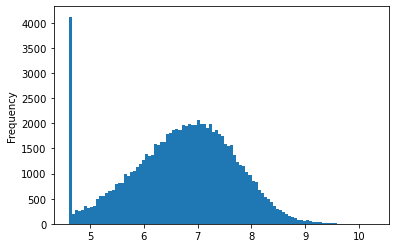

In [29]:
df_wkly_grid['grazing_secs'].transform(lambda x: np.log(100+x)).plot.hist(bins=100)

[Text(0.0, 1, 'None'),
 Text(111.1111111111111, 1, ''),
 Text(222.2222222222222, 1, 'Low'),
 Text(333.3333333333333, 1, ''),
 Text(444.4444444444444, 1, 'Avg.'),
 Text(555.5555555555555, 1, ''),
 Text(666.6666666666666, 1, 'Hi'),
 Text(777.7777777777777, 1, ''),
 Text(888.8888888888888, 1, 'V. Hi'),
 Text(1000.0, 1, '')]

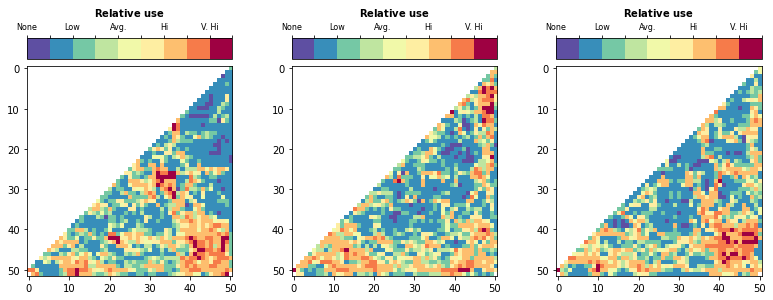

In [30]:
import xarray as xr
xr_dat_past = df_wkly_grid[df_wkly_grid['Pasture'] == '20SE'].set_index(['Year', 'season_str',
                                                                        'UTM_Y', 'UTM_X']).to_xarray()

from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.5, 4.0, 1000]
rel_use_labels = ['None', '', 'Low', '', 'Avg.', '', 'Hi', '', 'V. Hi', '']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm_rel_use = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))

yr = 2017
xr_dat_early = xr_dat_past.sel(Year=yr, season_str='early')
xr_dat_mid = xr_dat_past.sel(Year=yr, season_str='mid')
xr_dat_late = xr_dat_past.sel(Year=yr, season_str='late')

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
im1 = ax1.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
cax1.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.set_xticklabels(rel_use_labels)

im2 = ax2.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position('top')
cax2.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar2.ax.tick_params(labelsize=8)
cbar2.ax.set_xticklabels(rel_use_labels)

im3 = ax3.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)
cbar3.ax.set_xticklabels(rel_use_labels)

In [31]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'season_str'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
PC_dmt,,,,,,,,
Bare,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0
Bare_veg,9.0,3.0,81.0,3.0,9.0,30.0,6.0,141.0
C3,NaN,69.0,1359.0,NaN,9.0,39.0,3.0,1479.0
C3_C4_mix,1014.0,1524.0,987.0,978.0,258.0,2085.0,2760.0,9606.0
C4,3006.0,999.0,705.0,2961.0,3552.0,2316.0,1038.0,14577.0
Saltgrass,NaN,1221.0,924.0,NaN,NaN,12.0,150.0,2307.0
Shrub,NaN,6.0,42.0,NaN,NaN,NaN,33.0,81.0
UNK,NaN,30.0,27.0,27.0,51.0,33.0,6.0,174.0


In [32]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'season_str'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
TPC_c,,,,,,,,
Flat Plains,978.0,444.0,1908.0,798.0,2397.0,396.0,2772.0,9693.0
Highlands,810.0,813.0,129.0,624.0,261.0,1368.0,210.0,4215.0
Lowlands,966.0,1785.0,1308.0,1347.0,492.0,1191.0,498.0,7587.0
Open Slopes,1263.0,723.0,780.0,1158.0,726.0,1512.0,516.0,6678.0
Other,12.0,87.0,NaN,45.0,3.0,48.0,NaN,195.0


In [33]:
"""
Combine rare classes to 'Other'
"""
#df_wkly_grid[df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])] = 'Other'
df_wkly_grid['PC_dmt'].replace({'Bare_veg': 'Other', 'Bare': 'Other', 'UNK': 'Other', 'Shrub': 'Other'}, 
                               inplace=True)
#df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
tpc_dmt_summary2 = df_wkly_grid.groupby(['Pasture', 'season_str'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary2['Total'] = tpc_dmt_summary2.sum(axis=1)
display(tpc_dmt_summary2)

print('\n')

pc_dmt_summary2 = df_wkly_grid.groupby(['Pasture', 'season_str'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary2['Total'] = pc_dmt_summary2.sum(axis=1)
display(pc_dmt_summary2)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
TPC_c,,,,,,,,
Flat Plains,978.0,444.0,1908.0,798.0,2397.0,396.0,2772.0,9693.0
Highlands,810.0,813.0,129.0,624.0,261.0,1368.0,210.0,4215.0
Lowlands,966.0,1785.0,1308.0,1347.0,492.0,1191.0,498.0,7587.0
Open Slopes,1263.0,723.0,780.0,1158.0,726.0,1512.0,516.0,6678.0
Other,12.0,87.0,NaN,45.0,3.0,48.0,NaN,195.0


Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
PC_dmt,,,,,,,,
C3,NaN,69.0,1359.0,NaN,9.0,39.0,3.0,1479.0
C3_C4_mix,1014.0,1524.0,987.0,978.0,258.0,2085.0,2760.0,9606.0
C4,3006.0,999.0,705.0,2961.0,3552.0,2316.0,1038.0,14577.0
Other,9.0,39.0,150.0,33.0,60.0,63.0,45.0,399.0
Saltgrass,NaN,1221.0,924.0,NaN,NaN,12.0,150.0,2307.0


In [34]:
"""
Save training data for optional analysis in R
"""
df_wkly_grid.to_csv(inDIR + 'training_grazing_time_gridded.csv', index=False)

In [25]:
min_class_n = 10
fit_method = 'newton'
max_iters = 1000
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_secs ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
#m2a = m0 + ' + Biomass'
m2a = m0 + ' + Biomass + I(Biomass**2)'
m2b = m0 + ' + CP'
#m2d = m2a + ' + CP' 
#m2e = m2a + ' + CP + Biomass:CP'
m2c = m2a + ' + CP'
m2d = m2a + ' + CP + Biomass:CP + I(Biomass**2):CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    #'M2e': m2e,
    #'M2f': m2f,
    #'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [26]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['Year', 'season', 'Pasture', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['season_str', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': group[0][0],
            'season_str': group[0][1],
            'Pasture': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: invalid value encountered in log
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2735: RuntimeWarning: invalid value encountered in log
  dalpha = (dgpart + np.log(a1)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: inval

In [27]:
# check how many times model failed to converge
null_veg_mod_ct = df_results.groupby(['Year', 'season', 'model'])['AIC'].apply(lambda x: np.sum(np.isnan(x)))
display(null_veg_mod_ct[null_veg_mod_ct > 0])

Year    season  model
2016.0  early   M0       1
                M2a      1
                M2b      1
                M2c      1
                M2d      1
                M3b      1
        mid     M2a      1
                M2c      1
2017.0  early   M2a      1
2018.0  early   M2b      2
                M2c      2
                M2d      2
Name: AIC, dtype: int64

In [28]:
"""
Calculate stats on forage condition and plant community models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_FC'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_PC'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

In [29]:
# print the forage conditions results by year and season

fc_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M2']))].groupby(
['Year', 'season_str', 'model']).aggregate(
func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
      'top_model_FC': np.sum, 'candidate_model_FC': np.sum}).sort_values(['Year', 'season_str', 'AICd_FC'],
                                                                                     ascending=[True, True, True]).reset_index()
#fc_results['top_model_FC'] = np.round(fc_results['top_model_FC']/fc_results['steer_ct'], 2)
#fc_results['candidate_model_FC'] = np.round(fc_results['candidate_model_FC']/fc_results['steer_ct'], 2)

fc_results['selected'] = ''
for grp, data in fc_results.groupby(['Year', 'season_str']):
    if (data['AICd_FC'] < 2.0).any():
        simp_mod_tmp = data['model'][data[data['AICd_FC'] < 2.0]['model'].str.strip('M2').apply(
            lambda x: ord(x)).idxmin()]
        fc_results.loc[(fc_results['Year'] == grp[0]) &
                       (fc_results['season_str'] == grp[1]) & 
                       (fc_results['AICd_FC'] < 2.0) &
                       (fc_results['model'] == simp_mod_tmp), 'selected'] = '*'
    else:
        simp_mod_tmp = data['model'][data[(
            data['AICd_FC'] - data['AICd_FC'].min()) < 2.0]['model'].str.strip('M2').apply(
            lambda x: ord(x)).idxmin()]
        fc_results.loc[(fc_results['Year'] == grp[0]) &
                       (fc_results['season_str'] == grp[1]) & 
                       (fc_results['AICd_FC'] == data['AICd_FC'].min()), 'selected'] = '*'
                    # (fc_results['model'].str[-1] == data[data['AICd_FC'] < 2.0]['model'].str[-1].min() # for simplist model

fc_results['season'] = pd.Categorical(fc_results['season_str'], ['early', 'mid', 'late'])
with pd.option_context("display.max_rows", None):
    display(fc_results.set_index(['Year', 'season']).drop(columns='season_str'))

model     AICd_FC       AICw_FC  top_model_FC  \
Year   season                                                 
2016.0 early    M2d    0.763333  7.086113e-01             4   
       early    M2c   13.480000  2.629986e-01             2   
       early    M2a   59.391667  2.838586e-02             0   
       early    M2b   82.575000  4.220644e-06             0   
       late     M2d    0.254286  7.080560e-01             5   
       late     M2c   12.968571  2.133265e-01             1   
       late     M2a   28.314286  7.861744e-02             1   
       late     M2b   64.130000  8.095639e-08             0   
       mid      M2d    0.398571  7.573807e-01             6   
       mid      M2c   10.836667  2.782014e-01             1   
       mid      M2a   87.916667  4.821072e-03             0   
       mid      M2b  181.488571  2.856021e-05             0   
2017.0 early    M2d    0.658571  7.027319e-01             5   
       early    M2c   20.041429  2.618863e-01             2   
       early    M2a   40.891667  3.720401e-02             0   
       early    M2b   96.048571  3.492562e-03             0   
       late     M2d    1.015714  6.478397e-01             5   
       late     M2c    4.297143  2.769651e-01             1   
       late     M2a   61.787143  4.362026e-04             0   
       late     M2b  113.995714  7.475903e-02             1   
       mid      M2d    0.372857  6.759088e-01             5   
       mid      M2c    5.528571  3.240912e-01             2   
       mid      M2a  108.657143  4.493395e-12             0   
       mid      M2b  121.967143  6.741600e-13             0   
2018.0 early    M2d    0.546000  6.785361e-01             3   
       early    M2c    2.816000  2.875100e-01             2   
       early    M2a   38.091429  2.716831e-01             2   
       early    M2b   76.064000  5.359751e-02             0   
       late     M2d    1.718571  5.984786e-01             4   
       late     M2c    8.871429  2.198713e-01             2   
       late     M2a   10.671429  1.422471e-01             1   
       late     M2b   32.860000  3.940307e-02             0   
       mid      M2d    2.217143  5.926066e-01             4   
       mid      M2c   21.081429  1.280454e-01             0   
       mid      M2a   41.914286  2.793479e-01             3   
       mid      M2b   93.584286  8.692525e-11             0   

               candidate_model_FC selected  
Year   season                               
2016.0 early                    4        *  
       early                    2           
       early                    0           
       early                    0           
       late                     7        *  
       late                     4           
       late                     1           
       late                     0           
       mid                      6        *  
       mid                      3           
       mid                      0           
       mid                      0           
2017.0 early                    6        *  
       early                    3           
       early                    1           
       early                    0           
       late                     5        *  
       late                     3           
       late                     0           
       late                     1           
       mid                      6        *  
       mid                      4           
       mid                      0           
       mid                      0           
2018.0 early                    5        *  
       early                    3           
       early                    3           
       early                    1           
       late                     4        *  
       late                     3           
       late                     2           
       late                     1           
       mid                      4        *  
       mid                      3           

In [30]:
# print the plant community results by year and season
pc_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M3']))].groupby(
['Year', 'season_str', 'model']).aggregate(
func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
      'top_model_PC': np.sum, 'candidate_model_PC': np.sum}).sort_values(['Year', 'season_str', 'AICd_PC'],
                                                                                     ascending=[True, True, True]).reset_index()

#pc_results['top_model_PC'] = np.round(pc_results['top_model_PC']/pc_results['steer_ct'], 2)
#pc_results['candidate_model_PC'] = np.round(pc_results['candidate_model_PC']/pc_results['steer_ct'], 2)

pc_results['selected'] = ''
for grp, data in pc_results.groupby(['Year', 'season_str']):
    if (data['AICd_PC'] < 2.0).any():
        simp_mod_tmp = data['model'][data[data['AICd_PC'] < 2.0]['model'].str.strip('M3').apply(
            lambda x: ord(x)).idxmin()]
        pc_results.loc[(pc_results['Year'] == grp[0]) &
                       (pc_results['season_str'] == grp[1]) & 
                       (pc_results['AICd_PC'] < 2.0) &
                       (pc_results['model'] == simp_mod_tmp), 'selected'] = '*'
    else:
        simp_mod_tmp = data['model'][data[(
            data['AICd_PC'] - data['AICd_PC'].min()) < 2.0]['model'].str.strip('M3').apply(
            lambda x: ord(x)).idxmin()]
        pc_results.loc[(pc_results['Year'] == grp[0]) &
                       (pc_results['season_str'] == grp[1]) & 
                       (pc_results['AICd_PC'] == data['AICd_PC'].min()), 'selected'] = '*'

pc_results['season'] = pd.Categorical(pc_results['season_str'], ['early', 'mid', 'late'])        
with pd.option_context("display.max_rows", None):
    display(pc_results.set_index(['Year', 'season']).drop(columns='season_str'))

model     AICd_PC       AICw_PC  top_model_PC  \
Year   season                                                 
2016.0 early    M3d    0.000000  8.658090e-01             7   
       early    M3c   14.644286  9.289476e-02             0   
       early    M3a   50.621429  4.129625e-02             0   
       early    M3b   89.283333  1.990555e-08             0   
       late     M3d    0.177143  7.912486e-01             6   
       late     M3c   18.700000  8.751091e-02             1   
       late     M3a   27.938571  1.212397e-01             0   
       late     M3b   59.082857  7.479075e-07             0   
       mid      M3d    0.882857  7.447175e-01             5   
       mid      M3c   30.941429  6.597167e-02             0   
       mid      M3a   44.472857  5.861117e-03             0   
       mid      M3b  112.620000  1.834497e-01             2   
2017.0 early    M3d    0.558571  7.662271e-01             5   
       early    M3c   19.567143  2.334829e-01             2   
       early    M3b   54.801429  8.889782e-05             0   
       early    M3a   63.335714  2.010793e-04             0   
       late     M3d    0.895714  5.908847e-01             3   
       late     M3c    6.837143  3.133535e-01             3   
       late     M3a   23.081429  9.575750e-02             1   
       late     M3b   57.291429  4.279445e-06             0   
       mid      M3d    0.381429  5.996857e-01             5   
       mid      M3c    5.302857  2.596568e-01             1   
       mid      M3a   21.417143  1.357298e-01             1   
       mid      M3b   28.725714  4.927668e-03             0   
2018.0 early    M3d    0.882857  6.184479e-01             4   
       early    M3c   26.524286  2.042273e-01             1   
       early    M3a   41.691429  1.206068e-01             1   
       early    M3b   84.047143  5.671795e-02             1   
       late     M3d    2.478571  4.835219e-01             4   
       late     M3c    2.987143  2.652864e-01             1   
       late     M3a   10.674286  1.139474e-01             1   
       late     M3b   19.530000  1.372443e-01             1   
       mid      M3d    0.662857  6.470396e-01             5   
       mid      M3c   26.512857  2.266432e-01             1   
       mid      M3a   34.028571  1.255100e-01             1   
       mid      M3b   84.111429  8.071836e-04             0   

               candidate_model_PC selected  
Year   season                               
2016.0 early                    7        *  
       early                    2           
       early                    1           
       early                    0           
       late                     7        *  
       late                     1           
       late                     2           
       late                     0           
       mid                      5        *  
       mid                      1           
       mid                      0           
       mid                      2           
2017.0 early                    6        *  
       early                    2           
       early                    0           
       early                    0           
       late                     7        *  
       late                     4           
       late                     1           
       late                     0           
       mid                      7        *  
       mid                      3           
       mid                      2           
       mid                      0           
2018.0 early                    5        *  
       early                    4           
       early                    1           
       early                    1           
       late                     4        *  
       late                     3           
       late                     1           
       late                     2           
       mid                      6        *  
       mid                      4           

In [31]:
"""
Define the top vegetation models for each season
"""
model_dict_top = {}
for yr in df_results['Year'].unique():
    model_dict_top[yr] = {}
    for seas in df_results['season_str'].unique():
        model_dict_top[yr][seas] = {}
        model_dict_top[yr][seas]['M2_top'] = model_dict[fc_results[(fc_results['Year'] == yr) &
                                                                   (fc_results['season_str'] == seas) &
                                                                   (fc_results['selected'] == '*')]['model'].values[0]]
        model_dict_top[yr][seas]['M3_top'] = model_dict[pc_results[(pc_results['Year'] == yr) &
                                                               (pc_results['season_str'] == seas) &
                                                               (pc_results['selected'] == '*')]['model'].values[0]]
            

model_dict_veg = {}
for yr in df_results['Year'].unique():
    model_dict_veg[yr] = {}
    for seas in df_results['season_str'].unique():  
        model_dict_veg[yr][seas] = {}
        m4a = model_dict_top[yr][seas]['M2_top'] + re.sub(re.escape(m0), '', model_dict_top[yr][seas]['M3_top'])
        model_dict_veg[yr][seas]['M4a'] = m4a
        if 'PC_dmt' in m4a:
            if 'Biomass' in m4a:
                m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):I(Biomass**2)'
                model_dict_veg[yr][seas]['M4b'] = m4b
            if 'CP' in m4a:
                m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
                model_dict_veg[yr][seas]['M4c'] = m4c
                if 'Biomass' in m4a:
                    m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
                    model_dict_veg[yr][seas]['M4f'] = m4f
        if 'PC_div' in m4a:
            if 'Biomass' in m4a:
                m4d = m4a + ' + PC_div:Biomass + PC_div:I(Biomass**2)'
                model_dict_veg[yr][seas]['M4d'] = m4d
            if 'CP' in m4a:
                m4e = m4a + ' + PC_div:CP'
                model_dict_veg[yr][seas]['M4e'] = m4e
                if 'Biomass' in m4a:
                    m4g = m4d + ' + PC_div:CP'
                    model_dict_veg[yr][seas]['M4g'] = m4g
                    if 'PC_dmt' in m4a:
                        m4h = m4b + ' + PC_div:Biomass + PC_div:I(Biomass**2) + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'
                        model_dict_veg[yr][seas]['M4h'] = m4h


In [32]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    yr_tmp = group[0][0]
    seas = group[0][1]
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['Year', 'season_str', 'Pasture', 'model', 'formula', 'AIC'])  
    
    # run forage condition models for negative binomial
    for i in model_dict_veg[yr_tmp][seas]:
        form = model_dict_veg[yr_tmp][seas][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': yr_tmp,
            'season_str': seas,
            'Pasture': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: invalid value encountered in log
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2735: RuntimeWarning: invalid value encountered in log
  dalpha = (dgpart + np.log(a1)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2736: RuntimeWarning: invalid value encountered in log
  - np.log(a1+mu) - (y-mu)/(a1+mu)).sum() * da1
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(li

In [33]:
# check how many times model failed to converge
null_veg_mod_ct = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'season', 'model'])['AIC'].apply(lambda x: np.sum(np.isnan(x)))
display(null_veg_mod_ct[null_veg_mod_ct > 0])

Year  season  model
2018  early   M4a      1
              M4b      1
              M4c      2
              M4d      2
              M4e      2
              M4f      1
              M4g      2
              M4h      1
Name: AIC, dtype: int64

In [34]:
"""
Analyze the top vegetation models
"""

# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['Year', 'season', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_VEG'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
veg_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M4']))].groupby(
['Year', 'season_str', 'model']).aggregate(
func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
      'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}).sort_values(['Year', 'season_str', 'AICd_VEG'],
                                                                                     ascending=[True, True, True]).reset_index()

#veg_results['top_model_VEG'] = np.round(veg_results['top_model_VEG']/veg_results['steer_ct'], 2)
#veg_results['candidate_model_VEG'] = np.round(veg_results['candidate_model_VEG']/veg_results['steer_ct'], 2)

veg_results['selected'] = ''
for grp, data in veg_results.groupby(['Year', 'season_str']):
        if (data['AICd_VEG'] < 2.0).any():
            simp_mod_tmp = data['model'][data[data['AICd_VEG'] < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results.loc[(veg_results['Year'] == grp[0]) &
                           (veg_results['season_str'] == grp[1]) & 
                           (veg_results['AICd_VEG'] < 2.0) &
                           (veg_results['model'] == simp_mod_tmp), 'selected'] = '*'
        else:
            simp_mod_tmp = data['model'][data[(
                data['AICd_VEG'] - data['AICd_VEG'].min()) < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results.loc[(veg_results['Year'] == grp[0]) &
                           (veg_results['season_str'] == grp[1]) & 
                           (veg_results['AICd_VEG'] == data['AICd_VEG'].min()), 'selected'] = '*'
            
veg_results['season'] = pd.Categorical(veg_results['season_str'], ['early', 'mid', 'late'])
with pd.option_context("display.max_rows", None):
    display(veg_results.set_index(['Year', 'season']))

season_str model   AICd_VEG  AICw_VEG  top_model_VEG  \
Year season                                                        
2016 early       early   M4h   2.241429  0.470064              3   
     early       early   M4f   7.201429  0.254930              2   
     early       early   M4c  12.958571  0.140903              1   
     early       early   M4g  27.461429  0.032851              0   
     early       early   M4e  27.697143  0.097912              1   
     early       early   M4b  33.474286  0.000976              0   
     early       early   M4d  36.697143  0.000754              0   
     early       early   M4a  36.988571  0.001610              0   
     late         late   M4h   3.521429  0.429388              4   
     late         late   M4f   7.824286  0.118860              1   
     late         late   M4c  10.104286  0.039885              0   
     late         late   M4g  11.461429  0.102242              0   
     late         late   M4d  11.942857  0.116168              1   
     late         late   M4b  14.155714  0.063595              0   
     late         late   M4e  17.487143  0.039597              0   
     late         late   M4a  17.562857  0.090265              1   
     mid           mid   M4c   4.902857  0.312407              2   
     mid           mid   M4h   6.732857  0.212573              2   
     mid           mid   M4g   7.962857  0.088475              0   
     mid           mid   M4d   8.772857  0.134450              2   
     mid           mid   M4f   8.991429  0.049855              0   
     mid           mid   M4e  10.622857  0.045673              0   
     mid           mid   M4a  11.938571  0.086693              1   
     mid           mid   M4b  14.398571  0.069875              1   
2017 early       early   M4h   2.707143  0.417413              3   
     early       early   M4f  10.114286  0.199153              1   
     early       early   M4g  20.248571  0.202627              2   
     early       early   M4b  21.550000  0.118608              1   
     early       early   M4c  22.674286  0.000912              0   
     early       early   M4d  23.534286  0.060000              0   
     early       early   M4e  29.061429  0.000654              0   
     early       early   M4a  32.911429  0.000633              0   
     late         late   M4d   4.280000  0.280313              3   
     late         late   M4a   5.247143  0.139440              1   
     late         late   M4c   5.324286  0.119158              1   
     late         late   M4g   5.537143  0.141527              0   
     late         late   M4b   6.641429  0.072427              0   
     late         late   M4e   6.784286  0.057711              0   
     late         late   M4f   7.481429  0.147848              2   
     late         late   M4h   8.400000  0.041577              0   
     mid           mid   M4h   2.465714  0.345709              2   
     mid           mid   M4g   9.577143  0.165786              1   
     mid           mid   M4f  10.192857  0.147661              1   
     mid           mid   M4d  12.101429  0.127896              1   
     mid           mid   M4b  13.572857  0.053273              1   
     mid           mid   M4c  15.741429  0.108900              1   
     mid           mid   M4e  17.300000  0.025928              0   
     mid           mid   M4a  18.602857  0.024848              0   
2018 early       early   M4f   4.070000  0.261183              2   
     early       early   M4h   5.326667  0.109725              0   
     early       early   M4c   5.720000  0.224206              1   
     early       early   M4g  11.448000  0.096689              0   
     early       early   M4d  11.808000  0.201923              2   
     early       early   M4e  15.166000  0.038103              0   
     early       early   M4b  21.750000  0.095779              1   
     early       early   M4a  27.183333  0.065878              0   
     late         late   M4h   7.451429  0.260815              2   


In [35]:
# print the results by pasture
veg_results2 = df_results.loc[df_results['model'].str.contains(
'|'.join(['M4']))].groupby(
['Pasture', 'model']).aggregate(
func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
      'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}).sort_values(['Pasture', 'AICd_VEG'],
                                                                                     ascending=[True, True]).reset_index()

#veg_results['top_model_VEG'] = np.round(veg_results['top_model_VEG']/veg_results['steer_ct'], 2)
#veg_results['candidate_model_VEG'] = np.round(veg_results['candidate_model_VEG']/veg_results['steer_ct'], 2)

veg_results2['selected'] = ''
for grp, data in veg_results2.groupby(['Pasture']):
        if (data['AICd_VEG'] < 2.0).any():
            simp_mod_tmp = data['model'][data[data['AICd_VEG'] < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results2.loc[(veg_results2['Pasture'] == grp[0]) &
                           (veg_results2['AICd_VEG'] < 2.0) &
                           (veg_results2['model'] == simp_mod_tmp), 'selected'] = '*'
        else:
            simp_mod_tmp = data['model'][data[(
                data['AICd_VEG'] - data['AICd_VEG'].min()) < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results2.loc[(veg_results2['Pasture'] == grp[0]) & 
                           (veg_results2['AICd_VEG'] == data['AICd_VEG'].min()), 'selected'] = '*'
with pd.option_context("display.max_rows", None):
    display(veg_results2.set_index(['Pasture']))

,model,AICd_VEG,AICw_VEG,top_model_VEG,candidate_model_VEG,selected
Pasture,,,,,,
15E,M4h,2.481111,0.350898,5,5,
15E,M4g,6.450000,0.203956,1,5,
15E,M4d,9.481111,0.221466,3,4,
15E,M4f,9.847778,0.060087,0,0,
15E,M4e,10.510000,0.108885,1,1,
15E,M4b,11.464444,0.014576,0,0,
15E,M4c,12.192222,0.014680,0,0,
15E,M4a,13.500000,0.025452,0,0,
17N,M4f,8.605556,0.168777,2,2,


In [36]:
"""
Define full models with TPC
"""
model_dict_tpc = {}
for yr in model_dict_top:
    model_dict_tpc[yr] = {}
    for seas in model_dict_top[yr]:
        model_dict_top[yr][seas]['M4_top'] = model_dict_veg[yr][seas][veg_results[(veg_results['Year'] == yr) &
                                                               (veg_results['season_str'] == seas) &
                                                               (veg_results['selected'] == '*')]['model'].values[0]]
        model_dict_tpc[yr][seas] = {
                'M2_tpc': model_dict_top[yr][seas]['M2_top'] + re.sub(re.escape(m0), '', m1),
                'M3_tpc': model_dict_top[yr][seas]['M3_top'] + re.sub(re.escape(m0), '', m1),
                'M5': model_dict_top[yr][seas]['M4_top'] + re.sub(re.escape(m0), '', m1)
            }

In [37]:
"""
Run TPC models
"""
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'Pasture'])):
    yr_tmp = group[0][0]
    seas = group[0][1]
    
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
               
    df_results_tmp = pd.DataFrame(columns=['Year', 'season_str', 'Pasture', 'model', 'formula', 'AIC'])

    # run TPC models for negative binomial
    for i in model_dict_tpc[yr_tmp][seas]:
        form = model_dict_tpc[yr_tmp][seas][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': yr_tmp,
            'season_str': seas,
            'Pasture': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: overflow encountered in square
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: invalid

In [38]:
"""
Calculate results for final models
"""
for yr in model_dict_top:
    for seas in model_dict_top[yr]:
    
        # calculate AIC weights for the topography interaction models
        df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                    m1, 
                                                  model_dict_top[yr][seas]['M2_top'],
                                                                    model_dict_top[yr][seas]['M3_top'], 
                                                  model_dict_top[yr][seas]['M4_top'],
                                                  model_dict_tpc[yr][seas]['M5']])) &
                       (df_results['season_str'] == seas) & 
                       (df_results['Year'] == yr), 
                       'AICw_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                                                 m1, 
                                                                                                 model_dict_top[yr][seas]['M2_top'],
                                                                                                 model_dict_top[yr][seas]['M3_top'], 
                                                                                                 model_dict_top[yr][seas]['M4_top'],
                                                                                                 model_dict_tpc[yr][seas]['M5']])) &
                                                    (df_results['season_str'] == seas) &
                                                    (df_results['Year'] == yr)
                                                   ].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
            aicw_func)
        df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                    m1, 
                                                                    model_dict_top[yr][seas]['M2_top'],
                                                                    model_dict_top[yr][seas]['M3_top'], 
                                                                    model_dict_top[yr][seas]['M4_top'],
                                                                    model_dict_tpc[yr][seas]['M5']])) &
                       (df_results['season_str'] == seas) &
                       (df_results['Year'] == yr), 
                       'AICd_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                  m1, 
                                                  model_dict_top[yr][seas]['M2_top'],
                                                  model_dict_top[yr][seas]['M3_top'], 
                                                  model_dict_top[yr][seas]['M4_top'],
                                                  model_dict_tpc[yr][seas]['M5']])) &
                       (df_results['season_str'] == seas) &
                                                   (df_results['Year'] == yr)].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
            aicd_func)

df_results['top_model_ALL'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x == 0.0])
df_results['candidate_model_ALL'] = df_results.groupby(['Year', 'season_str', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

for yr in model_dict_top:
    print('-------- ' + str(yr) + ' ---------')
    for seas in model_dict_top[yr]:
        print('    ---------- ' + seas + ' ----------')
        df_top_mod_results_tmp = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                  m1, 
                                                  model_dict_top[yr][seas]['M2_top'],
                                                  model_dict_top[yr][seas]['M3_top'], 
                                                  model_dict_top[yr][seas]['M4_top'],
                                                  model_dict_tpc[yr][seas]['M5']])) &
                                                (df_results['season'] == seas) &
                                                (df_results['Year'] == yr)].groupby('model').aggregate(
            func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
                  'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1).sort_values(('AICd_ALL', 'median'))
        df_top_mod_results_tmp[('top_model_ALL', 'pct')] = df_top_mod_results_tmp[('top_model_ALL', 'sum')] / \
        df_top_mod_results_tmp[('top_model_ALL', 'sum')].sum()
        df_top_mod_results_tmp[('candidate_model_ALL', 'pct')] = df_top_mod_results_tmp[('candidate_model_ALL', 'sum')] / \
        df_top_mod_results_tmp[('top_model_ALL', 'sum')].sum()
        df_top_mod_results_tmp['selected'] = ''
            
        if (df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0).any():
            simp_mod_tmp = df_top_mod_results_tmp[df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0].iloc[
                pd.Series(df_top_mod_results_tmp[
                    df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0].index).apply(
                    lambda x: [int(s) for s in x if s.isdigit()][0]).idxmin()].name
            df_top_mod_results_tmp.loc[(df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0) &
                           (df_top_mod_results_tmp.index == simp_mod_tmp), 'selected'] = '*'
        else:
            df_top_mod_results_tmp.loc[(df_top_mod_results_tmp[('AICd_ALL', 'median')] == df_top_mod_results_tmp[('AICd_ALL', 'median')].min()), 
                                       'selected'] = '*'
        
        #df_top_mod_results_tmp.loc[((df_top_mod_results_tmp[('AICd_ALL', 'median')] - df_top_mod_results_tmp[('AICd_ALL', 'median')].min()) < 2.0) &
        #                           (df_top_mod_results_tmp[('AICw_ALL', 'mean')] == df_top_mod_results_tmp.loc[
        #                               (df_top_mod_results_tmp[('AICd_ALL', 'median')] 
        #                                - df_top_mod_results_tmp[('AICd_ALL', 'median')].min()) < 2.0, ('AICw_ALL', 'mean')].max()), 'selected'] = '*'
        df_top_mod_results_tmp[[('AICd_ALL', 'median'), 
                                ('AICd_ALL', 'std'), 
                                ('AICw_ALL', 'mean'), 
                                ('AICw_ALL', 'std'),
                                ('top_model_ALL', 'pct'),
                                ('candidate_model_ALL', 'pct')]] = df_top_mod_results_tmp[[('AICd_ALL', 'median'), 
                                                                                           ('AICd_ALL', 'std'), 
                                                                                           ('AICw_ALL', 'mean'), 
                                                                                           ('AICw_ALL', 'std'),
                                                                                           ('top_model_ALL', 'pct'),
                                                                                           ('candidate_model_ALL', 'pct')]].transform(lambda x: round(x, 2))
        df_top_mod_results_tmp[('AICd_ALL', 'std')] = df_top_mod_results_tmp[('AICd_ALL', 'std')].transform(lambda x: '(' + str(x) + ')').astype(str)
        df_top_mod_results_tmp[('AICw_ALL', 'std')] = df_top_mod_results_tmp[('AICw_ALL', 'std')].transform(lambda x: '(' + str(x) + ')').astype(str)
        df_top_mod_results_tmp = df_top_mod_results_tmp.drop(columns=[('top_model_ALL', 'sum'), ('candidate_model_ALL', 'sum')])
        display(df_top_mod_results_tmp)
        df_top_mod_results_tmp.to_csv(os.path.join(outDIR, 
                                                   'results_tables/', 'AIC_top_models_' + str(yr) + '_' + seas + '.csv'),
                                     encoding='utf-8')
        # add best model to model dictionary
        model_dict_top[yr][seas]['M_best'] = df_top_mod_results_tmp[df_top_mod_results_tmp['selected'] == '*'].index.values[0]

-------- 2016.0 ---------
    ---------- early ----------


AICd_ALL           AICw_ALL        top_model_ALL candidate_model_ALL  \
        median       std     mean    std           pct                 pct   
model                                                                        
M5        0.00     (0.0)      1.0  (0.0)           1.0                 1.0   
M4h      82.84   (28.08)      0.0  (0.0)           0.0                 0.0   
M2d     171.28    (48.7)      0.0  (0.0)           0.0                 0.0   
M3d     206.52  (134.66)      0.0  (0.0)           0.0                 0.0   
M1      208.11  (135.39)      0.0  (0.0)           0.0                 0.0   
M0      256.20  (165.72)      0.0  (0.0)           0.0                 0.0   

      selected  
                
model           
M5           *  
M4h             
M2d             
M3d             
M1              
M0

    ---------- late ----------


AICd_ALL           AICw_ALL         top_model_ALL candidate_model_ALL  \
        median       std     mean     std           pct                 pct   
model                                                                         
M5        0.00     (0.0)     0.94  (0.08)           1.0                 1.0   
M4h       5.92   (19.57)     0.06  (0.08)           0.0                 0.0   
M2d      46.01   (52.45)     0.00   (0.0)           0.0                 0.0   
M3d      59.66   (53.02)     0.00   (0.0)           0.0                 0.0   
M0       97.81  (116.05)     0.00   (0.0)           0.0                 0.0   
M1       97.92   (87.53)     0.00   (0.0)           0.0                 0.0   

      selected  
                
model           
M5           *  
M4h             
M2d             
M3d             
M0              
M1

    ---------- mid ----------


AICd_ALL           AICw_ALL         top_model_ALL candidate_model_ALL  \
        median       std     mean     std           pct                 pct   
model                                                                         
M5        0.00     (0.4)     0.88  (0.26)          0.86                1.00   
M4c      26.09   (29.19)     0.09   (0.2)          0.14                0.14   
M2d      54.96   (61.29)     0.02  (0.06)          0.00                0.00   
M3d     209.53  (127.66)     0.00   (0.0)          0.00                0.00   
M1      219.90  (201.39)     0.00   (0.0)          0.00                0.00   
M0      332.30  (224.82)     0.00   (0.0)          0.00                0.00   

      selected  
                
model           
M5           *  
M4c             
M2d             
M3d             
M1              
M0

-------- 2017.0 ---------
    ---------- early ----------


AICd_ALL           AICw_ALL        top_model_ALL candidate_model_ALL  \
        median       std     mean    std           pct                 pct   
model                                                                        
M5        0.00     (0.0)      1.0  (0.0)           1.0                 1.0   
M4h      76.47   (20.86)      0.0  (0.0)           0.0                 0.0   
M2d     206.28   (74.81)      0.0  (0.0)           0.0                 0.0   
M1      239.44   (94.63)      0.0  (0.0)           0.0                 0.0   
M3d     247.78   (91.17)      0.0  (0.0)           0.0                 0.0   
M0      401.56  (113.28)      0.0  (0.0)           0.0                 0.0   

      selected  
                
model           
M5           *  
M4h             
M2d             
M1              
M3d             
M0

    ---------- late ----------


AICd_ALL           AICw_ALL         top_model_ALL candidate_model_ALL  \
        median       std     mean     std           pct                 pct   
model                                                                         
M5        0.00     (0.6)     0.86  (0.26)          0.86                1.00   
M4d       8.73    (34.7)     0.14  (0.26)          0.14                0.14   
M2d      40.09    (37.9)     0.00   (0.0)          0.00                0.00   
M3d      97.35   (92.11)     0.00   (0.0)          0.00                0.00   
M1      134.46  (107.64)     0.00   (0.0)          0.00                0.00   
M0      188.64  (139.79)     0.00   (0.0)          0.00                0.00   

      selected  
                
model           
M5           *  
M4d             
M2d             
M3d             
M1              
M0

    ---------- mid ----------


AICd_ALL          AICw_ALL         top_model_ALL candidate_model_ALL  \
        median      std     mean     std           pct                 pct   
model                                                                        
M5        0.00    (2.4)     0.80  (0.35)          0.86                0.86   
M4h      12.08  (49.52)     0.18  (0.35)          0.14                0.14   
M2d      52.26  (60.19)     0.02  (0.06)          0.00                0.00   
M1      173.88  (59.16)     0.00   (0.0)          0.00                0.00   
M3d     236.47  (74.03)     0.00   (0.0)          0.00                0.00   
M0      261.30   (68.3)     0.00   (0.0)          0.00                0.00   

      selected  
                
model           
M5           *  
M4h             
M2d             
M1              
M3d             
M0

-------- 2018.0 ---------
    ---------- early ----------


AICd_ALL           AICw_ALL         top_model_ALL candidate_model_ALL  \
        median       std     mean     std           pct                 pct   
model                                                                         
M5        0.00     (0.0)     1.00   (0.0)          0.86                0.86   
M4f      24.66   (16.33)     0.00   (0.0)          0.00                0.00   
M1       93.95  (167.56)     0.14  (0.38)          0.14                0.14   
M2d     102.33   (43.94)     0.00   (0.0)          0.00                0.00   
M3d     108.57  (120.93)     0.00   (0.0)          0.00                0.00   
M0      205.59  (197.83)     0.00   (0.0)          0.00                0.00   

      selected  
                
model           
M5           *  
M4f             
M1              
M2d             
M3d             
M0

    ---------- late ----------


AICd_ALL          AICw_ALL         top_model_ALL candidate_model_ALL  \
        median      std     mean     std           pct                 pct   
model                                                                        
M5        0.00   (6.06)     0.56  (0.41)          0.57                0.71   
M4h       3.63   (6.67)     0.19  (0.26)          0.14                0.43   
M2d      19.44  (39.88)     0.09  (0.17)          0.14                0.29   
M3d      24.04  (60.69)     0.02  (0.05)          0.00                0.00   
M1       37.21  (58.29)     0.06  (0.11)          0.00                0.29   
M0       55.78  (68.94)     0.07  (0.19)          0.14                0.14   

      selected  
                
model           
M5           *  
M4h             
M2d             
M3d             
M1              
M0

    ---------- mid ----------


AICd_ALL           AICw_ALL         top_model_ALL candidate_model_ALL  \
        median       std     mean     std           pct                 pct   
model                                                                         
M5        0.00    (0.84)     0.87  (0.29)          0.86                0.86   
M4d      13.00    (17.6)     0.12  (0.25)          0.14                0.14   
M2d      37.84   (74.14)     0.02  (0.04)          0.00                0.00   
M3d      85.93   (49.77)     0.00   (0.0)          0.00                0.00   
M1       96.63    (92.8)     0.00   (0.0)          0.00                0.00   
M0      143.62  (174.86)     0.00   (0.0)          0.00                0.00   

      selected  
                
model           
M5           *  
M4d             
M2d             
M3d             
M1              
M0

In [39]:
df_wkly_grid.groupby(['Year', 'season_str']).apply(lambda x: len(x['Pasture'].unique())).reset_index().groupby(['Year', 'season_str']).apply(lambda x: np.sum(x[0]))

Year  season_str
2016  early         7
      late          7
      mid           7
2017  early         7
      late          7
      mid           7
2018  early         7
      late          7
      mid           7
dtype: int64

In [63]:
# calculate AIC weights for the topography interaction models
for yr in model_dict_top:
    for seas in model_dict_top[yr]:
        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M2_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M2_tpc']), 
                       'AICw_TPC2'] = df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) &
                                                     (df_results['formula'] == model_dict_top[yr][seas]['M2_top']) | 
                                                     (df_results['formula'] == model_dict_tpc[yr][seas]['M2_tpc'])]['AIC'].apply(
            aicw_func)
        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M2_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M2_tpc']), 
                       'AICd_TPC2'] = df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M2_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M2_tpc'])]['AIC'].apply(
            aicd_func)
        df_results.loc[(df_results['season'] == seas) &
                       (df_results['Year'] == yr), 'top_model_TPC2'] = df_results.loc[(df_results['season'] == seas) &
                                                                                      (df_results['Year'] == yr)]['AICd_TPC2'].apply(
            lambda x: [int(i) for i in x == x.min()])
        df_results.loc[(df_results['season'] == seas) &
                       (df_results['Year'] == yr), 'candidate_model_TPC2'] = df_results.loc[(df_results['season'] == seas) &
                                                                                            (df_results['Year'] == yr)]['AICd_TPC2'].apply(
            lambda x: [int(i) for i in x <= 2.0])

        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M3_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M3_tpc']), 
                       'AICw_TPC3'] = df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M3_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M3_tpc'])]['AIC'].apply(
            aicw_func)
        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M3_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M3_tpc']), 
                       'AICd_TPC3'] = df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M3_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M3_tpc'])]['AIC'].apply(
            aicd_func)
        df_results.loc[(df_results['season'] == seas) & 
                       (df_results['Year'] == yr), 'top_model_TPC3'] = df_results.loc[(df_results['season'] == seas) & 
                                                                                      (df_results['Year'] == yr)]['AICd_TPC3'].apply(
            lambda x: [int(i) for i in x == x.min()])
        df_results.loc[(df_results['season'] == seas) &
                       (df_results['Year'] == yr), 'candidate_model_TPC3'] = df_results.loc[(df_results['season'] == seas) & 
                                                                                              (df_results['Year'] == yr)]['AICd_TPC3'].apply(
            lambda x: [int(i) for i in x <= 2.0])

        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M4_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M5']), 
                       'AICw_TPC4'] =     df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M4_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M5'])]['AIC'].apply(
            aicw_func)
        df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M4_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M5']), 
                       'AICd_TPC4'] =    df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) & 
                       (df_results['formula'] == model_dict_top[yr][seas]['M4_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M5'])]['AIC'].apply(
            aicd_func)
        df_results.loc[(df_results['season'] == seas) &
                       (df_results['Year'] == yr), 'top_model_TPC4'] = df_results.loc[
            (df_results['season'] == seas) &
            (df_results['Year'] == yr)]['AICd_TPC4'].apply(
            lambda x: [int(i) for i in x == x.min()])
        df_results.loc[(df_results['season'] == seas) & 
                       (df_results['Year'] == yr), 'candidate_model_TPC4'] = df_results.loc[(df_results['season'] == seas) & 
                                                                                            (df_results['Year'] == yr)]['AICd_TPC4'].apply(
            lambda x: [int(i) for i in x <= 2.0])

AttributeError: 'float' object has no attribute 'min'

In [183]:
# print the results of adding TPC to forage quality
for yr in model_dict_top:
    print('--------- ' + str(yr) + ' ----------------------------')
    for seas in model_dict_top[yr]:
        print('     ---------- ' + seas + ' ----------')
        display(df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) &
                       (df_results['formula'] == model_dict_top[yr][seas]['M2_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M2_tpc'])].groupby(
        ['week', 'model', 'Pasture']).aggregate(
        func={'AICd_TPC2': np.mean, 'AICw_TPC2': np.mean, 
              'top_model_TPC2': np.max, 'candidate_model_TPC2': np.max}).groupby(
            ['model'])[['top_model_TPC2', 'candidate_model_TPC2',
                        'AICw_TPC2', 'AICd_TPC2']].aggregate(
            func={'AICd_TPC2': [np.median, np.std], 'AICw_TPC2': [np.mean, np.std], 
                  'top_model_TPC2': np.sum, 'candidate_model_TPC2': np.sum}, axis=1).sort_values([('AICd_TPC2', 'median')]))


--------- 2017.0 ----------------------------
     ---------- early ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc    0.0000  1.053752  0.881275  0.224132          103.0   
M2c      11.7525  9.633147  0.187788  0.319194            8.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                     9.0

     ---------- mid ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc      0.00  1.053752  0.881275  0.224132          103.0   
M2c         1.85  9.611264  0.385314  0.343220           15.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    21.0

     ---------- late ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc      0.00  1.053752  0.881275  0.224132          103.0   
M2c         1.36  6.365829  0.459926  0.375493           19.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    24.0

--------- 2018.0 ----------------------------
     ---------- early ----------


AICd_TPC2            AICw_TPC2           top_model_TPC2  \
          median        std      mean       std            sum   
model                                                            
M2_tpc     0.000   1.053752  0.881275  0.224132          103.0   
M2c        9.725  11.576439  0.258977  0.345708           11.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    13.0

     ---------- mid ----------


AICd_TPC2            AICw_TPC2           top_model_TPC2  \
          median        std      mean       std            sum   
model                                                            
M2d        0.650  22.084700  0.491032  0.360006           20.0   
M2_tpc     1.885   2.017343  0.508968  0.360006           21.0   

       candidate_model_TPC2  
                        sum  
model                        
M2d                    24.0  
M2_tpc                 22.0

     ---------- late ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2a         0.00  6.287000  0.647915  0.295827           26.0   
M2_tpc      2.65  2.002166  0.362755  0.293696           12.0   

       candidate_model_TPC2  
                        sum  
model                        
M2a                    31.0  
M2_tpc                 17.0

--------- 2016.0 ----------------------------
     ---------- early ----------


AICd_TPC2            AICw_TPC2           top_model_TPC2  \
          median        std      mean       std            sum   
model                                                            
M2_tpc    0.0000   1.053752  0.881275  0.224132          103.0   
M2c      11.3825  14.017297  0.161286  0.246464           10.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    13.0

     ---------- mid ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc     0.000  1.053752  0.881275  0.224132          103.0   
M2c        0.195  8.717962  0.534355  0.360558           27.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    29.0

     ---------- late ----------


AICd_TPC2           AICw_TPC2           top_model_TPC2  \
          median       std      mean       std            sum   
model                                                           
M2_tpc       0.0  1.053752  0.881275  0.224132          103.0   
M2c          0.0  5.681514  0.579698  0.329749           29.0   

       candidate_model_TPC2  
                        sum  
model                        
M2_tpc                111.0  
M2c                    34.0

In [184]:
# print the results of adding TPC to plant community
for yr in model_dict_top:
    print('--------- ' + str(yr) + ' ---------------------------')
    for seas in model_dict_top[yr]:
        print('    --------- ' + seas + ' ---------')
        display(df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) &
                       (df_results['formula'] == model_dict_top[yr][seas]['M3_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M3_tpc'])].groupby(
        ['week', 'model', 'Pasture']).aggregate(
        func={'AICd_TPC3': np.mean, 'AICw_TPC3': np.mean, 
              'top_model_TPC3': np.max, 'candidate_model_TPC3': np.max}).groupby(
            ['model'])[['top_model_TPC3', 'candidate_model_TPC3',
                        'AICw_TPC3', 'AICd_TPC3']].aggregate(
            func={'AICd_TPC3': [np.median, np.std], 'AICw_TPC3': [np.mean, np.std], 
                  'top_model_TPC3': np.sum, 'candidate_model_TPC3': np.sum}, axis=1).sort_values([('AICd_TPC3', 'median')]))


--------- 2017.0 ---------------------------
    --------- early ---------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc    0.0000  0.454423  0.963541  0.095828           68.0   
M3c       5.7275  9.306664  0.214341  0.288757           10.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 70.0  
M3c                    14.0

    --------- mid ---------


AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3_tpc    0.0000   0.454423  0.963541  0.095828           68.0   
M3c       3.7375  13.373760  0.289120  0.359388            9.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 70.0  
M3c                    14.0

    --------- late ---------


AICd_TPC3          AICw_TPC3           top_model_TPC3  \
          median      std      mean       std            sum   
model                                                          
M3_tpc      0.00  0.94782  0.868167  0.194676           49.0   
M3a         3.39  7.41108  0.392074  0.369443           16.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 63.0  
M3a                    19.0

--------- 2018.0 ---------------------------
    --------- early ---------


AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3_tpc      0.00   0.454423  0.963541  0.095828           68.0   
M3c         6.97  10.867236  0.251892  0.330348            9.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 70.0  
M3c                    13.0

    --------- mid ---------


AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3_tpc     0.000   0.947820  0.868167  0.194676           49.0   
M3a        0.725  18.655312  0.502523  0.357973           21.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 63.0  
M3a                    24.0

    --------- late ---------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc       0.0  0.947820  0.868167  0.194676           49.0   
M3a          0.0  2.855166  0.603087  0.323577           24.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 63.0  
M3a                    26.0

--------- 2016.0 ---------------------------
    --------- early ---------


AICd_TPC3            AICw_TPC3           top_model_TPC3  \
          median        std      mean       std            sum   
model                                                            
M3_tpc    0.0000   0.454423  0.963541  0.095828           68.0   
M3c      13.8425  14.269386  0.172973  0.263835            9.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 70.0  
M3c                    13.0

    --------- mid ---------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3d        0.445  6.932605  0.494041  0.371733           27.0   
M3_tpc     1.155  2.188703  0.518608  0.367424           23.0   

       candidate_model_TPC3  
                        sum  
model                        
M3d                    28.0  
M3_tpc                 28.0

    --------- late ---------


AICd_TPC3           AICw_TPC3           top_model_TPC3  \
          median       std      mean       std            sum   
model                                                           
M3_tpc       0.0  0.947820  0.868167  0.194676           49.0   
M3a          0.0  6.428037  0.551728  0.332685           28.0   

       candidate_model_TPC3  
                        sum  
model                        
M3_tpc                 63.0  
M3a                    32.0

In [185]:
# print the results of adding TPC to forage quality
for yr in model_dict_top:
    print('--------- ' + str(yr) + ' ---------------------------------------')
    for seas in model_dict_top[yr]:
        print('     ---------- ' + seas + ' ----------')
        display(df_results.loc[(df_results['season'] == seas) & (df_results['Year'] == yr) &
                       (df_results['formula'] == model_dict_top[yr][seas]['M4_top']) | 
                       (df_results['formula'] == model_dict_tpc[yr][seas]['M5'])].groupby(
        ['week', 'model', 'Pasture']).aggregate(
        func={'AICd_TPC4': np.mean, 'AICw_TPC4': np.mean, 
              'top_model_TPC4': np.max, 'candidate_model_TPC4': np.max}).groupby(
            ['model'])[['top_model_TPC4', 'candidate_model_TPC4',
                        'AICw_TPC4', 'AICd_TPC4']].aggregate(
            func={'AICd_TPC4': [np.median, np.std], 'AICw_TPC4': [np.mean, np.std], 
                  'top_model_TPC4': np.sum, 'candidate_model_TPC4': np.sum}, axis=1).sort_values([('AICd_TPC4', 'median')]))


--------- 2017.0 ---------------------------------------
     ---------- early ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M5        0.000  0.392906  0.960065  0.090118           61.0   
M4a       6.245  8.786514  0.246248  0.319744           13.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    67.0  
M4a                   13.0

     ---------- mid ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M5         0.00  0.392906  0.960065  0.090118           61.0   
M4a        2.37  9.591259  0.395823  0.371389           17.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    67.0  
M4a                   18.0

     ---------- late ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4a       0.000  5.035079  0.549969  0.348612           26.0   
M5        1.055  1.611287  0.645696  0.261862           24.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   27.0  
M5                    32.0

--------- 2018.0 ---------------------------------------
     ---------- early ----------


AICd_TPC4            AICw_TPC4           top_model_TPC4  \
         median        std      mean       std            sum   
model                                                           
M5         0.00   0.392906  0.960065  0.090118           61.0   
M4a        4.68  10.078566  0.318108  0.365162           13.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    67.0  
M4a                   15.0

     ---------- mid ----------


AICd_TPC4            AICw_TPC4           top_model_TPC4  \
         median        std      mean       std            sum   
model                                                           
M4a      0.0025  15.260487  0.551331  0.331787           24.0   
M5       1.9600   2.013954  0.448669  0.331787           17.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   26.0  
M5                    21.0

     ---------- late ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4a        0.00  2.043315  0.687522  0.260893           26.0   
M5         2.33  2.315414  0.322243  0.258868           10.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   31.0  
M5                    18.0

--------- 2016.0 ---------------------------------------
     ---------- early ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M5         0.00  0.392906  0.960065  0.090118           61.0   
M4a        8.47  8.211936  0.194728  0.272204           10.0   

      candidate_model_TPC4  
                       sum  
model                       
M5                    67.0  
M4a                   14.0

     ---------- mid ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4a       0.605  5.202600  0.528032  0.374715           27.0   
M5        2.080  2.179974  0.496172  0.368071           22.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   29.0  
M5                    25.0

     ---------- late ----------


AICd_TPC4           AICw_TPC4           top_model_TPC4  \
         median       std      mean       std            sum   
model                                                          
M4a       0.000  4.512845  0.584938  0.327202           29.0   
M5        1.055  1.611287  0.645696  0.261862           24.0   

      candidate_model_TPC4  
                       sum  
model                       
M4a                   33.0  
M5                    32.0

In [40]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
       
model_list_fnl = ['M0', 'M1', 'M2_bm', 'M2_top', 'M3_pc', 'M3_top', 'M4_top', 'M_best']

model_dict_fnl = {}

for mod in model_list_fnl:
    model_dict_fnl[mod] = {}
    for yr in model_dict_top:
        model_dict_fnl[mod][yr] = {}
        for seas in model_dict_top[yr]:
            if mod == 'M0':
                model_dict_fnl[mod][yr][seas] = m0
            elif mod == 'M1':
                model_dict_fnl[mod][yr][seas] = m1
            elif mod == 'M2_bm':
                model_dict_fnl[mod][yr][seas] = m2a
            elif mod == 'M3_pc':
                model_dict_fnl[mod][yr][seas] = m3a
            elif 'top' in mod:
                model_dict_fnl[mod][yr][seas] = model_dict_top[yr][seas][mod]
            elif mod == 'M_best':
                if model_dict_top[yr][seas]['M_best'] == 'M5':
                    model_dict_fnl[mod][yr][seas] = model_dict_tpc[yr][seas]['M5']
                elif 'M4' in model_dict_top[yr][seas]['M_best']:
                    model_dict_fnl[mod][yr][seas] = model_dict_veg[yr][seas][model_dict_top[yr][seas]['M_best']]
                elif ('M2' in model_dict_top[yr][seas]['M_best'] )| ('M3' in model_dict_top[yr][seas]['M_best']):
                    model_dict_fnl[mod][yr][seas] = model_dict[model_dict_top[yr][seas]['M_best']]
model_dict_fnl['M_best']

{2016.0: {'early': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):I(Biomass**2) + PC_div:Biomass + PC_div:I(Biomass**2) + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP + C(TPC_c, Treatment(reference="Flat Plains"))',
  'late': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):I(Biomass**2) + PC_div:Biomass + PC_div:I(Biomass**2) + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP + C(TPC_c, Treatment(reference="Flat Plains"))',
  'mid': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix

In [41]:
mod_list = ['M_best']
idx = 0
for mod in mod_list:
    print(mod + '\n')
    for yr in tqdm(df_wkly_grid['Year'].unique()):
        for seas in df_wkly_grid['season_str'].unique():
            form = model_dict_fnl[mod][yr][seas]
            for group in df_wkly_grid[(df_wkly_grid['Year'] == yr) & 
                                      (df_wkly_grid['season_str'] == seas)].groupby('Pasture'):
                # remove any locations related to a class with fewer than N observations
                data = group[1]
                data['Model'] = mod
                data['Formula'] = form
                data = data[~data['PC_dmt'].isin(
                    data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
                data = data[~data['TPC_c'].isin(
                    data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
                md_tmp = NegativeBinomial.from_formula(form, data, offset=np.log(data['grazing_wkly_sum']), missing='drop')
                try:
                    mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
                    if idx == 0:
                        if mdf_tmp.mle_retvals['converged']:
                            coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                      Pasture=group[0],
                                                      Year=yr,
                                                      season_str=seas,
                                                      Model=mod,
                                                      Formula=form))
                            idx += 1
                            df_mods_tmp = data
                        else:
                            continue
                    else:
                        if mdf_tmp.mle_retvals['converged']:
                            coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                                   Pasture=group[0], 
                                                                   Year=yr,
                                                                   season_str=seas,
                                                                   Model=mod,
                                                                   Formula=form)))
                            idx += 1
                            df_mods_tmp = df_mods_tmp.append(data)          
                        else:
                            continue
                    #print(group[0])
                except (ValueError, np.linalg.LinAlgError):
                    pass
                
coefs = coefs.rename_axis('Param').reset_index()
coefs['season'] = pd.Categorical(coefs['season_str'], ['early', 'mid', 'late'])

# drop seasons with null values for any coefficients
coefs = coefs[~coefs.groupby(['Year', 'season_str', 'Model'])['coef'].transform(np.any(np.isnan))]

M_best



  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: overflow encountered in square
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: invalid value encountered in true_divide
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: overflow encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**

In [54]:
yrly_mod_dict = {}
for yr in coefs['Year'].unique():
    print(yr)
    yrly_mod_dict[yr] = {}
    for seas in coefs['season_str'].unique():
        print(seas)
        yrly_mod_dict[yr][seas] = {}
        for mod in tqdm(mod_list):
            form = model_dict_fnl[mod][yr][seas]
            data = df_wkly_grid[(df_wkly_grid['Year'] == yr) & 
                                      (df_wkly_grid['season_str'] == seas)]
            # remove any locations related to a class with fewer than N observations
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
            md_tmp = NegativeBinomial.from_formula(form, data,
                                                   offset=np.log(data['grazing_wkly_sum']), 
                                                   missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, 
                                     method=fit_method, 
                                     disp=False)
                yrly_mod_dict[yr][seas][mod] = mdf_tmp
            except (ValueError, np.linalg.LinAlgError):
                print('Retrying with LBFGS')
                try:
                    mdf_tmp = md_tmp.fit(method="lbfgs")
                except (ValueError, np.linalg.LinAlgError):
                    print('Did not work')
                    pass

2016
early


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


late


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


mid


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


2017
early


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


late


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


Retrying with LBFGS
mid


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


2018
early


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


late


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


mid


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: divide by zero encountered in log
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: invalid value encountered in true_divide
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2873: RuntimeWarning: invalid value encountered in true_

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1062: RuntimeWarning: overflow encountered in exp


In [148]:
"""
Build top models for each year and season across all pastures
"""
yrly_mod_dict = {}
for yr in coefs['Year'].unique():
    print(yr)
    yrly_mod_dict[yr] = {}
    for seas in coefs['season_str'].unique():
        print(seas)
        yrly_mod_dict[yr][seas] = {}
        for mod in tqdm(mod_list):
            form = model_dict_fnl[mod][yr][seas]
            df_tmp = df_mods_tmp[(df_mods_tmp['Year'] == yr) & 
                                 (df_mods_tmp['season_str'] == seas) &  
                                 (df_mods_tmp['Model'] == mod)]
            coefs_tmp = coefs[(coefs['Year'] == yr) &
                              (coefs['season_str'] == seas) &
                              (coefs['Model'] == mod)][['Pasture', 'Param', 'coef']]
            md_tmp = NegativeBinomial.from_formula(form, df_tmp, 
                                                   offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
            except ValueError:
                mdf_tmp = md_tmp.fit(method="lbfgs")
            for idx, i in enumerate(mdf_tmp.params.index):
                mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
            coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
            mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
            mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
            yrly_mod_dict[yr][seas][mod] = mdf_tmp

2016
early


  0%|          | 0/1 [00:00<?, ?it/s]

late


  0%|          | 0/1 [00:00<?, ?it/s]

mid


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: invalid value encountered in log
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2735: RuntimeWarning: invalid value encountered in log
  dalpha = (dgpart + np.log(a1)


2017
early


  0%|          | 0/1 [00:00<?, ?it/s]

late


  0%|          | 0/1 [00:00<?, ?it/s]

mid


  0%|          | 0/1 [00:00<?, ?it/s]

2018
early


  0%|          | 0/1 [00:00<?, ?it/s]

late


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: invalid value encountered in log
  np.log(prob) - (y - mu)/(a1+mu))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2735: RuntimeWarning: invalid value encountered in log
  dalpha = (dgpart + np.log(a1)


mid


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [191]:
mod='M_best'
yr=2016
seas='mid'
form = model_dict_fnl[mod][yr][seas]
form = 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP' \
+ '+ I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div' \
+ '+ C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + C(TPC_c, Treatment(reference="Flat Plains"))'
data = df_wkly_grid[(df_wkly_grid['Year'] == yr) & 
                          (df_wkly_grid['season_str'] == seas)]
# remove any locations related to a class with fewer than N observations
data = data[~data['PC_dmt'].isin(
    data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
data = data[~data['TPC_c'].isin(
    data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
md_tmp = NegativeBinomial.from_formula(form, data,
                                       offset=np.log(1+data['grazing_wkly_sum']), 
                                       missing='drop')
mdf_tmp = md_tmp.fit(maxiter=max_iters, 
                         method=fit_method, 
                         disp=False)

In [55]:
yrly_mod_dict[2018]['early'][mod].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:           grazing_secs   No. Observations:                 9456
Model:               NegativeBinomial   Df Residuals:                     9423
Method:                           MLE   Df Model:                           32
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                 0.01023
Time:                        08:20:20   Log-Likelihood:                -71907.
converged:                       True   LL-Null:                       -72650.
Covariance Type:            nonrobust   LLR p-value:                1.983e-292
============================================================================================================================================
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -7.4493      0.033   -226.838      0.000      -7.514      -7.385
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]                           -0.1070      0.132     -0.809      0.419      -0.366       0.152
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                           -0.0369      0.035     -1.047      0.295      -0.106       0.032
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]                         0.7634      0.158      4.832      0.000       0.454       1.073
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]                     0.5285      0.106      4.999      0.000       0.321       0.736
C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]                   -0.1233      0.040     -3.101      0.002      -0.201      -0.045
C(TPC_c, Treatment(reference="Flat Plains"))[T.Lowlands]                     0.3438      0.034     10.004      0.000       0.276       0.411
C(TPC_c, Treatment(reference="Flat Plains"))[T.Open Slopes]                 -0.0515      0.034     -1.533      0.125      -0.117       0.014
C(TPC_c, Treatment(reference="Flat Plains"))[T.Other]                        0.0094      0.145      0.065      0.949      -0.275       0.294
dFence                                                                      -0.0673      0.012     -5.469      0.000      -0.091      -0.043
dTank                                                                       -0.1864      0.013    -14.154      0.000      -0.212      -0.161
Biomass                                                                     -0.3567      0.034    -10.454      0.000      -0.424      -0.290
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]:Biomass                    0.0227      0.098      0.231      0.817      -0.170       0.216
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:Biomass                    0.0011      0.056      0.020      0.984      -0.109       0.111
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]:Biomass                -0.0275      0.124     -0.221      0.825      -0.271       0.216
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]:Biomass             0.0146      0.099      0.148      0.882      -0.179       0.208
I(Biomass ** 2)                                                              0.0819      0.028      2.929      0.003       0.027       0.137
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]:I(Biomass ** 2)           -0.0025      0.056     -0.044      0.965      -0.112       0.107
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:I(Biomass ** 2)            0.1196      0.053      2.252      0.024       0.016       0.224
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]:I(Biomass ** 2)        -0.0327      0.036     -0.917      0.359      -0.103       0.03

In [51]:
yrly_mod_dict[2018]['early'][mod].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:           grazing_secs   No. Observations:                 9456
Model:               NegativeBinomial   Df Residuals:                     9423
Method:                           MLE   Df Model:                           32
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                 0.01023
Time:                        21:35:04   Log-Likelihood:                -71907.
converged:                       True   LL-Null:                       -72650.
Covariance Type:            nonrobust   LLR p-value:                1.983e-292
============================================================================================================================================
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -7.4493      0.033   -226.837      0.000      -7.514      -7.385
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]                           -0.1071      0.132     -0.809      0.418      -0.366       0.152
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                           -0.0368      0.035     -1.046      0.296      -0.106       0.032
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]                         0.7630      0.158      4.831      0.000       0.453       1.073
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]                     0.5289      0.106      5.003      0.000       0.322       0.736
C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]                   -0.1233      0.040     -3.101      0.002      -0.201      -0.045
C(TPC_c, Treatment(reference="Flat Plains"))[T.Lowlands]                     0.3438      0.034     10.003      0.000       0.276       0.411
C(TPC_c, Treatment(reference="Flat Plains"))[T.Open Slopes]                 -0.0515      0.034     -1.533      0.125      -0.117       0.014
C(TPC_c, Treatment(reference="Flat Plains"))[T.Other]                        0.0091      0.145      0.062      0.950      -0.276       0.294
dFence                                                                      -0.0673      0.012     -5.468      0.000      -0.091      -0.043
dTank                                                                       -0.1864      0.013    -14.153      0.000      -0.212      -0.161
Biomass                                                                     -0.3566      0.034    -10.452      0.000      -0.423      -0.290
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]:Biomass                    0.0226      0.098      0.230      0.818      -0.170       0.215
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:Biomass                    0.0011      0.056      0.019      0.985      -0.109       0.111
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]:Biomass                -0.0284      0.124     -0.229      0.819      -0.272       0.215
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]:Biomass             0.0143      0.099      0.145      0.885      -0.179       0.208
I(Biomass ** 2)                                                              0.0820      0.028      2.929      0.003       0.027       0.137
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]:I(Biomass ** 2)           -0.0025      0.056     -0.044      0.965      -0.112       0.107
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:I(Biomass ** 2)            0.1196      0.053      2.252      0.024       0.016       0.224
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]:I(Biomass ** 2)        -0.0326      0.036     -0.914      0.360      -0.103       0.03

In [52]:
"""
Save final training/test dataset, model results and models to disk
"""
df_wkly_grid_out = pd.concat([df_wkly_grid, df_wkly_grid_test])
#df_wkly_grid_out['CP'].describe()

df_wkly_grid_out.to_csv(os.path.join(inDIR, 'full_grazing_time_gridded_all_for_model.csv'))

df_results.to_csv(os.path.join(outDIR, 'full_grazing_intensity_model_results.csv'))

coefs.to_csv(os.path.join(outDIR, 'full_grazing_intensity_model_coefficients.csv'))

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))

for yr in yrly_mod_dict:
    for seas in yrly_mod_dict[yr]:
        for m in yrly_mod_dict[yr][seas]:
            yrly_mod_dict[yr][seas][m].save(os.path.join(outDIR, 
                                                     'seas/',
                                                     'grazing_intensity_mod_' + str(yr) + '_' + seas + '_' + m + '.pkl'))

In [90]:
df_wkly_grid_test[df_wkly_grid_test['CP'].notnull()]#[['Pasture', 'season', 'Year', 'UTM_X', 'UTM_Y']]#.drop_duplicates()

,Pasture,season,Year,UTM_X,UTM_Y,Biomass,CP,DOM,dFence,dTank,dCorner,PC_div,TPC_c,PC_dmt,grazing_secs,grazing_wkly_sum,grazing_rel_freq,mod_data
66136,15E,early,2017,520005.0,4520715.0,-0.669137,-3.042304,65.847448,-1.319569,-0.726882,451.575248,-0.135507,Flat Plains,C4,224,1755684,0.000000,test
66137,15E,early,2017,520005.0,4520745.0,-0.737662,-3.159421,65.925832,-1.319569,-0.817893,421.835556,-1.216906,Flat Plains,C4,262,1755684,0.000000,test
66138,15E,early,2017,520005.0,4520775.0,-0.574595,-3.138481,65.939800,-1.319569,-0.912043,392.135523,-1.063320,Flat Plains,C4,0,1755684,0.000000,test
66139,15E,early,2017,520005.0,4520805.0,-0.724527,-2.808878,65.902488,-1.319569,-1.006192,362.484897,-1.253833,Flat Plains,C4,4,1755684,0.000000,test
66140,15E,early,2017,520005.0,4520835.0,-0.829908,-2.837374,65.792788,-1.319569,-1.097204,332.896879,-0.762794,Lowlands,C4,48,1755684,0.000000,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5322873,7NW,late,2018,525465.0,4522665.0,1.282900,0.428600,59.607950,-1.338809,-0.104726,132.419399,-1.532793,Flat Plains,Saltgrass,462,219315,2.805937,test
5322874,7NW,late,2018,525465.0,4522695.0,0.701841,0.331024,59.396970,-1.228027,-0.118112,121.718511,-1.402284,Flat Plains,Saltgrass,894,219315,5.429670,test
5322875,7NW,late,2018,525465.0,4522725.0,0.102102,0.230209,59.186340,-1.338809,-0.124805,117.880848,-1.451948,Highlands,Saltgrass,90,219315,0.546611,test
5323188,7NW,late,2018,525495.0,4522695.0,-0.093468,0.257106,59.033535,-1.338809,-0.017714,92.965434,0.148105,Flat Plains,Saltgrass,535,219315,3.249299,test


In [78]:
import xarray as xr
xr_dat_past = df_wkly_grid[df_wkly_grid['Pasture'] == '7NW'].set_index(['Year', 'season', 'UTM_Y', 'UTM_X']).to_xarray()

In [79]:
pc_dmt_dict = {
    'C4': 1.0,
    'C3_C4_mix': 2.0,
    'C3': 3.0,
    'Saltgrass': 4.0,
    'Other': 5.0
}

tpc_dict = {
    'Highlands': 1.0,
    'Open Slopes': 2.0,
    'Flat Plains': 3.0,
    'Lowlands': 4.0,
    'Other': 5.0
}

pred_grps_dict = {
    'Low': 1,
    'Mod. Low': 2,
    'Avg.': 3,
    'Mod. Hi': 4,
    'Hi': 5
}


def convert_from_dict(x, set_dict):
    return set_dict[x] if x in set_dict else x
    
xr_dat_past['PC_dmt_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['PC_dmt'],
                                           kwargs={'set_dict': pc_dmt_dict}, vectorize=True, dask='parallelized')
xr_dat_past['TPC_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['TPC_c'],
                                           kwargs={'set_dict': tpc_dict}, vectorize=True, dask='parallelized')
#xr_dat_past['pred_seas_grp_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['pred_seas_grp'],
#                                                   kwargs={'set_dict': pred_grps_dict}, vectorize=True, dask='parallelized')
#xr_dat_past['PC_div'] = xr_dat_past['PC_div'].fillna(0)

KeyError: 'PC_div_orig'

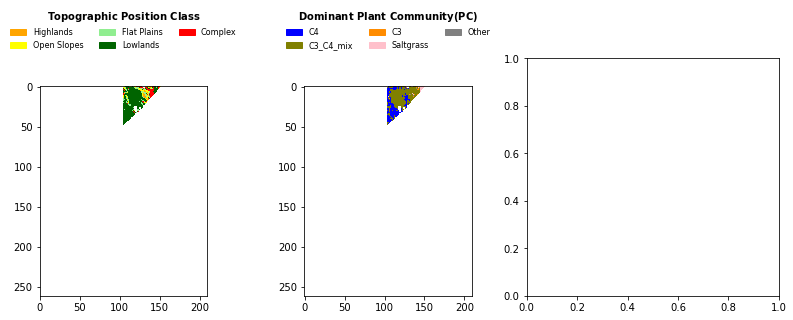

In [81]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable


tpc_labels = ['Complex' if x == 'Other' else x for x in tpc_dict.keys()]

tpc_cmap = colors.ListedColormap(['orange', 'yellow', 'lightgreen', 'darkgreen', 'red'])
tpc_patches =[mpatches.Patch(color=c, label=list(tpc_labels)[i]) for i, c in enumerate(tpc_cmap.colors)]

pc_dmt_cmap = colors.ListedColormap(['blue', 'olive', 'darkorange', 'pink', 'grey'])
pc_patches =[mpatches.Patch(color=c, label=list(pc_dmt_dict.keys())[i]) for i, c in enumerate(pc_dmt_cmap.colors)]

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.5, 4.0, 1000]
rel_use_labels = ['None', '', 'Low', '', 'Avg.', '', 'Hi', '', 'V. Hi', '']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm_rel_use = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))

yr = 2017
xr_dat_early = xr_dat_past.sel(Year=yr, season='early')
xr_dat_mid = xr_dat_past.sel(Year=yr, season='mid')
xr_dat_late = xr_dat_past.sel(Year=yr, season='late')

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax1.imshow(xr_dat_early['TPC_val'].sortby('UTM_Y', ascending=False).data, cmap=tpc_cmap)
ax1.legend(handles=tpc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Topographic\ Position\ Class}$", title_fontsize=10)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cax1.axes.set_visible(False)

ax2.imshow(xr_dat_early['PC_dmt_val'].sortby('UTM_Y', ascending=False).data, cmap=pc_dmt_cmap)
ax2.legend(handles=pc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Dominant\ Plant\ Community (PC)}$", title_fontsize=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cax2.axes.set_visible(False)

im3 = ax3.imshow(xr_dat_early['PC_div_orig'].sortby('UTM_Y', ascending=False).data, cmap='cividis', vmin=0.0, vmax=1.5)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{PC\ Diversity\ (Shannon\ H)}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)

gs2 = GridSpec(3, 3, top=0.65, bottom=0.02, hspace=0.01)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])
im4 = ax4.imshow(xr_dat_early['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='10%', pad=cax_pad)
cbar4 = fig.colorbar(im4, cax=cax4, orientation='horizontal')
cax4.xaxis.set_ticks_position('top')
cax4.set_title("$\\bf{Biomass\ (kg/ha)}$", fontsize=10)
cbar4.ax.tick_params(labelsize=8)
#cax4left = divider4.append_axes('left', size='5%', pad=0.05)
#cax4left.yaxis.set_label("early-season")

im5 = ax5.imshow(xr_dat_early['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('top', size='10%', pad=cax_pad)
cbar5 = fig.colorbar(im5, cax=cax5, orientation='horizontal')
cax5.xaxis.set_ticks_position('top')
cax5.set_title("$\\bf{Crude\ Protein\ (\%)}$", fontsize=10)
cbar5.ax.tick_params(labelsize=8)

im6 = ax6.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('top', size='10%', pad=cax_pad)
cbar6 = fig.colorbar(im6, cax=cax6, orientation='horizontal')
cax6.xaxis.set_ticks_position('top')
cax6.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar6.ax.tick_params(labelsize=8)
cbar6.ax.set_xticklabels(rel_use_labels)

ax8 = fig.add_subplot(gs2[1, 0])
ax9 = fig.add_subplot(gs2[1, 1])
ax10 = fig.add_subplot(gs2[1, 2])
ax8.imshow(xr_dat_mid['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax9.imshow(xr_dat_mid['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax10.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

ax12 = fig.add_subplot(gs2[2, 0])
ax13 = fig.add_subplot(gs2[2, 1])
ax14 = fig.add_subplot(gs2[2, 2])
ax12.imshow(xr_dat_late['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax13.imshow(xr_dat_late['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax14.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax8, ax9, ax10, ax12, ax13, ax14]:
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
ax1.set_ylabel("$\\bf{static}$", fontdict={'size': 12}, labelpad=15)
ax4.set_ylabel("$\\bf{early{-}season}$" + "\n(week 21)", fontdict={'size': 12}, labelpad=15)
ax8.set_ylabel("$\\bf{mid{-}season}$" + "\n(week 27)", fontdict={'size': 12}, labelpad=15)
ax12.set_ylabel("$\\bf{late{-}season}$" + "\n(week 33)", fontdict={'size': 12}, labelpad=15)


#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Pasture_example_' + str(yr) + '_no_pred.png',
#            bbox_inches='tight', dpi=300)

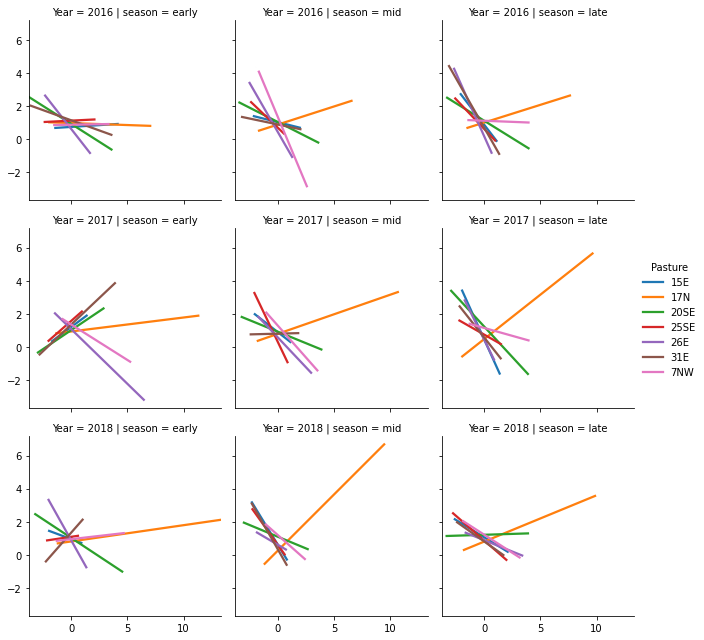

In [78]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='Pasture')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

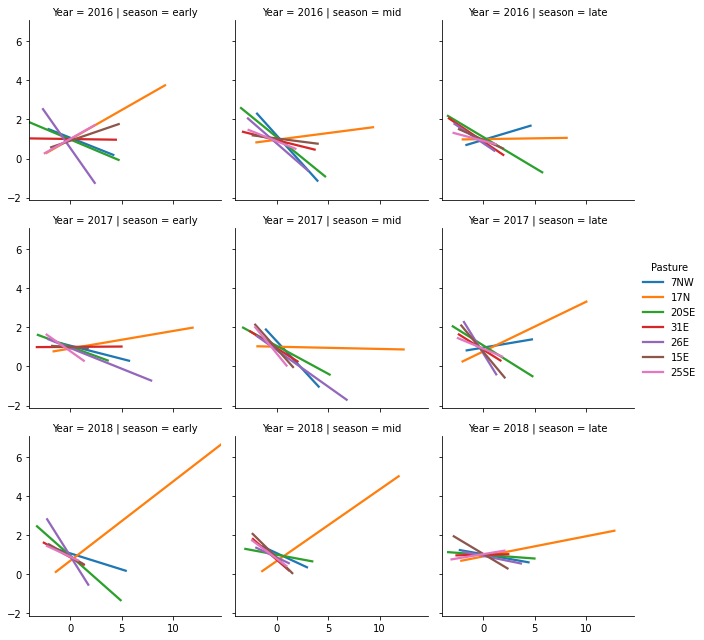

In [143]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='Pasture')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

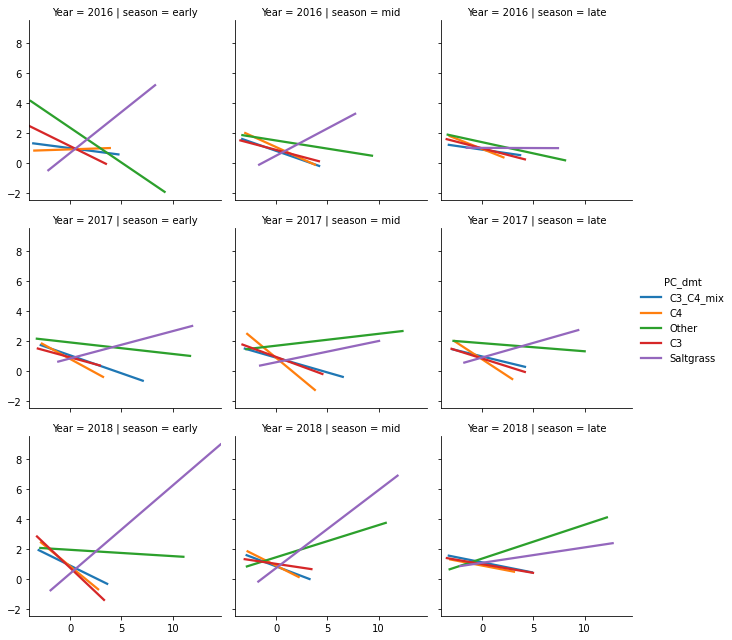

In [148]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='PC_dmt')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

In [34]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(model_dict_fnl):
        form = model_dict_fnl[mod][seas]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
        md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
        try:
            mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby(
                ['week', 'Pasture', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
"""
Build top models for each season and for each pasture
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for seas in tqdm(coefs['Season'].unique()):
        past_mod_dict[past][seas] = {}
        for mod in model_dict_fnl:
            form = model_dict_fnl[mod][seas]
            df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & 
                                 (df_mods_tmp['season'] == seas) &
                                 (df_mods_tmp['Model'] == mod)]
            coefs_tmp = coefs[(coefs['Pasture'] == past) & 
                              (coefs['Season'] == seas) & 
                              (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
            md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
            except ValueError:
                mdf_tmp = md_tmp.fit(method="lbfgs")
            for idx, i in enumerate(mdf_tmp.params.index):
                mdf_tmp.params[idx] = coefs_tmp.groupby(
                    ['week', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
            coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
            mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
            mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
            past_mod_dict[past][seas][mod] = mdf_tmp        

15E


  0%|          | 0/3 [00:00<?, ?it/s]

17N


  0%|          | 0/3 [00:00<?, ?it/s]

20SE


  0%|          | 0/3 [00:00<?, ?it/s]

26E


  0%|          | 0/3 [00:00<?, ?it/s]

31E


  0%|          | 0/3 [00:00<?, ?it/s]

7NW


  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
for seas in seas_mod_dict:
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_full_' + seas + '_' + m + '.pkl'))
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for past in past_mod_dict:
        for m in past_mod_dict[past][seas]:
            past_mod_dict[past][seas][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_full_' + past + '_' + seas + '_' + m + '.pkl'))

In [41]:
"""
Print out all combos of Pastures available for each week across a set range of weeks
"""
df_seas_unique = df_wkly_grid_full.groupby(['Year', 'week']).agg({'Pasture': lambda x: x.unique(),
                                                                  'Steer_ID': lambda x: x.unique()}).reset_index()
df_seas = df_seas_unique.groupby(['Year', 'week']).agg(
    {'Pasture': lambda x: [i for i in list(df_wkly_grid_full['Pasture'].unique()) if all(i in y for y in x)],
     'Steer_ID': lambda x: [i for i in list(df_wkly_grid_full['Steer_ID'].unique()) if all(i in y for y in x)]}).reset_index()
df_seas['season'] = df_seas['week'].apply(lambda x: season_func(x))
df_seas

,Year,week,Pasture,Steer_ID,season
0,2016,19,[24W],"[3770_D1_2016, 3771_D1_2016]",early
1,2016,20,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
2,2016,21,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
3,2016,22,"[5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, 25SE]","[2285_D1_2016, 2286_D1_2016, 2288_D1_2016, 228...",early
4,2016,23,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
5,2016,24,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 15E, 25SE]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
6,2016,25,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[3770_D1_2016, 2285_D1_2016, 2286_D1_2016, 228...",early
7,2016,27,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid
8,2016,28,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 15E, 25SE]","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid
9,2016,29,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid


In [73]:
# specific final pastures
#fnl_pastures = ['7NW', '17N', '20SE', '15E', '26E', '31E']
fnl_pastures = ['19N', '20SE', '31E', '26E', '15E', '25SE']

# create mask of final weeks based on pastures
wk_mask = [all(j in i for j in fnl_pastures) for i in df_seas['Pasture']]

# check which weeks are in final dataset
df_seas[wk_mask].groupby(['Year', 'season'])['week'].count().reset_index()

,Year,season,week
0,2016,early,3
1,2016,late,5
2,2016,mid,5
3,2017,early,2
4,2017,late,4
5,2017,mid,1
6,2018,late,4
7,2018,mid,1


In [52]:
#past_combos
past_combos_sum = np.array(
        [sum(all(elem in test2 for elem in test1) for test2 in df_seas['Pasture']) for test1 in past_combos])
top_combos = np.array(past_combos)[(past_combos_sum == np.max(past_combos_sum)) | (past_combos_sum > 5)]

In [66]:
for combo in past_combos:
    print(list(combo))

['24W', '5E', '7NW', '17N', '19N', '20SE']
['24W', '5E', '7NW', '17N', '19N', '31E']
['24W', '5E', '7NW', '17N', '19N', '26E']
['24W', '5E', '7NW', '17N', '19N', '15E']
['24W', '5E', '7NW', '17N', '19N', '25SE']
['24W', '5E', '7NW', '17N', '20SE', '31E']
['24W', '5E', '7NW', '17N', '20SE', '26E']
['24W', '5E', '7NW', '17N', '20SE', '15E']
['24W', '5E', '7NW', '17N', '20SE', '25SE']
['24W', '5E', '7NW', '17N', '31E', '26E']
['24W', '5E', '7NW', '17N', '31E', '15E']
['24W', '5E', '7NW', '17N', '31E', '25SE']
['24W', '5E', '7NW', '17N', '26E', '15E']
['24W', '5E', '7NW', '17N', '26E', '25SE']
['24W', '5E', '7NW', '17N', '15E', '25SE']
['24W', '5E', '7NW', '19N', '20SE', '31E']
['24W', '5E', '7NW', '19N', '20SE', '26E']
['24W', '5E', '7NW', '19N', '20SE', '15E']
['24W', '5E', '7NW', '19N', '20SE', '25SE']
['24W', '5E', '7NW', '19N', '31E', '26E']
['24W', '5E', '7NW', '19N', '31E', '15E']
['24W', '5E', '7NW', '19N', '31E', '25SE']
['24W', '5E', '7NW', '19N', '26E', '15E']
['24W', '5E', '7NW

In [7]:
if len(reqd_pastures) > 0:
    reqd_mask = [all(p in x for p in reqd_pastures) for x in top_combos]
    top_combos = top_combos[reqd_mask]
top_combos = [list(x) for x in top_combos]
top_dates = []
for combo in top_combos:
    mask = [all(j in i for j in combo) for i in df_seas['Pasture']]
    top_dates.append(
        [datetime.date.fromisocalendar(2017, x, 1).strftime('%b %d') for x in df_seas['week'][mask].values])
print('\n\n' + '-------------------------------------' + '\n' + 
      'No. Pastures: ' + str(r) + '\n'
      'Max no. weeks: ' + str(np.max(past_combos_sum)) + '\n' +
      '-------------------------------------')
for dates, combo in [(y, x) for y, x in sorted(zip(top_dates, top_combos), key=lambda pair: len(pair[0]), reverse=True)]:
    print('Pastures=' + str(len(combo)) + ': ' + str(combo))
    past_mask = [all(j in i for j in combo) for i in df_seas['Pasture']]
    #steer_mask = [all([j in y] for y in i for j in combo) for i in df_gps_wkly['Pasture_Steer_ID']]
    steer_ct = [sum([sum([j in y for j in combo]) for y in x]) for x in df_seas['Steer_ID'][past_mask]]
    #steers = [len(x) for x in df_gps_wkly['Pasture_Steer_ID'][steer_mask]]
    #dates = [datetime.date.fromisocalendar(2017, x, 1).strftime('%B %d') for x in df_gps_wkly['week'][mask].values]
    print('Weeks=' + str(len(dates)) + ' (start dates): ' + str(dates))
    print('Steers: ' + str(steer_ct) + '\n')



-------------------------------------
No. Pastures: 6
Max no. weeks: 22
-------------------------------------
Pastures=6: ['7NW', '17N', '19N', '20SE', '31E', '15E']
Weeks=22 (start dates): ['May 22', 'May 29', 'Jun 05', 'Jun 12', 'Jun 19', 'Jul 03', 'Jul 10', 'Jul 17', 'Jul 24', 'Jul 31', 'Aug 07', 'Aug 14', 'Aug 21', 'Sep 11', 'Sep 18', 'Sep 25', 'May 22', 'May 29', 'Jul 31', 'Sep 11', 'Sep 18', 'Sep 25']
Steers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Pastures=6: ['7NW', '17N', '20SE', '31E', '26E', '15E']
Weeks=22 (start dates): ['May 22', 'May 29', 'Jun 05', 'Jun 19', 'Jul 03', 'Jul 17', 'Jul 24', 'Jul 31', 'Aug 07', 'Aug 14', 'Aug 21', 'Sep 11', 'Sep 18', 'Sep 25', 'May 22', 'May 29', 'Jun 05', 'Jul 10', 'Jul 24', 'Jul 31', 'Sep 11', 'Sep 18']
Steers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Pastures=6: ['17N', '19N', '20SE', '31E', '15E', '25SE']
Weeks=22 (start dates): ['May 29', 'Jun 05', 'Jun 12', 'Jun 19', 'Jul 03', 'J